# Statefarm Classification MDL Build
  - Input: exercise_40_train.csv
    - y : target variable
        - imbalance
          -  0.854925 with value 0
          -  0.145075 with value 1 
    - x1 ~ x100: feature variables  
      - x19
        - Apply converters={'x19': negative_converter}) to convert Excel negative value to Pandas negative value
          - negative_converter: user defined function to convert Excel negative value to Pandas negative value
      - 11 Categorical features
          - x3, x7, x24, x31, x33, x39, x60, x65, x77,x93, x99
      - Data clean  
        - Remove % from X7 and convert datatype from object to floating    
        - Consolidate days of the week - x3
          - Rename full name to abbreviation,  
            - .e.g.'Monday' -> 'Mon'
       - Get missing value ratio and drop features with missing value ratio  > 0.4 
         - drop features: x30, x44, x52, x55, x57 
       - Draw countplot for categorical features
         - Further investigation for X24 (Gender), X39 and x99
           -  All the values in x24 are 'male' and 'female' which are evenly distributed. Will drop x24
           -  All the values in x39 is '5-10 miles'. Will drop x39
           

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN 


from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import scale


from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error


from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import pickle

import re
import math


%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Define functions

In [3]:
vc = lambda df, feature : df[feature].value_counts()/len(df) # value_counts()
nr = lambda df, feature : df[feature].isnull().sum()/len(df) # Null value ratio
dp = lambda df, feature : df[feature].dtype # dtype of a feature 
vp = lambda df, feature : sns.violinplot(df[feature])
hp = lambda df, feature : df[feature].hist()

In [4]:
"""
  Module name: negative_converter 
  Purpose: convert Excel negative value to Pandas negative value
  - ref: https://stackoverflow.com/questions/53989077/how-to-convert-excel-negative-value-to-pandas-negative-value
  Parameter
   x: feature
"""

def negative_converter(x):
    # a somewhat naive implementation
    x = x.replace('$', '').replace(',', '')
    if '(' in x:
        x = '-' + x.strip('()')
    return float(x)



In [5]:
"""
 -  Remove % from X7 and convert datatype from object to floating 
 -  x3: Consolidate days of the week
    - Rename full name to abbreviation, e.g.; 'Monday'-> 'Mon'
"""
def data_clean(df):       
    df['x7'] = list(map(lambda x: float(re.sub('\%','',x))/100, df['x7'] ))
    
    sorted(df.x3.unique())
    d_day= {
    'Monday'   :'Mon',
    'Tuesday'  :'Tue',   
    'Wednesday':'Wed',
    'Friday'   :'Fri', 
    'Thursday' :'Thu', 
    'Saturday' :'Sat', 
    'Sunday'   :'Sun'}  
    for key, value in d_day.items():
        df.x3.replace(key, value, inplace = True)

In [6]:
def get_missing_ratio(df):
    a = df.isnull().sum()/len(df)
    missing_ratio = round(a[a != 0], 3) 
    var = df.columns    #pandas.core.indexes.base.Index
    var_drop = [ ]
    
    for i in range(df.columns.shape[0]):
        if a[i] > 0.4: #setting the threshold as 40%
            var_drop.append(var[i]) 
    print(f'missing_ratio \n {missing_ratio}\n')         
    return var_drop  

In [7]:
"""
Draw countplot for categorical features
"""
def draw_countplot(df): 
    non_num_var = df.dtypes [df.dtypes == 'O'].index.to_list()
    row = int(math.ceil(len(non_num_var)/2))
    for k, feature in enumerate(non_num_var):     
        plt.subplot(row,2, k+1)
        sns.countplot(y = feature, data = df)
        plt.show()

In [8]:
"""
 - Get  missing value ratio, data type and value count
"""
def edp(df, feature, title=''):
    print(f'\n{title} for feature {feature}')
    print(f'Misssing value ratio: {nr(df, feature)}')
    print(f'Data typg e: {dp(df, feature)}')
    print(f'Value counts \n{vc(df, feature)}') 

In [9]:
"""
 - Use target encoding to convert categorical feature to numerical feature
"""
def tar_enc(df, feature):      
    tenc=ce.TargetEncoder() 
    df_fea =tenc.fit_transform(df[feature],df['y'])
    df.drop(feature, axis = 1)
    df[feature] = df_fea  

In [10]:
""" 
Impute missing value for numerical features
"""
def impute_num(df, feature):    
    imputer = SimpleImputer(strategy='mean')
    df[feature] = imputer.fit_transform(df[feature].values.reshape(-1,1))[:,0]


In [11]:
"""
 - Evaluate model
"""
def eval_mdl(model, mdl_name, x_test, y_test):
    pred = model.predict(x_test)
    print( mdl_name )
    print( '' )
    print( 'R^2:', r2_score(y_test, pred ))
    print( 'MAE:', mean_absolute_error(y_test, pred))
    print()

In [12]:
"""
 - Model build & evaluation
"""
def bld_mdl(mdl):
    # define the model cross-validation configuration   
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the pipeline using cross validation and calculate MAE
    scores = cross_val_score(mdl, X_resampled, y_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
    # summarize the model performance
    print(f'AUC score Mean: {mean(scores):.3f}, Std: {std(scores):.3f}')

In [13]:
"""
 - Use pickle to save model
"""
def save_mdl(mdl,pkl_nam):
    mdl.fit( X_resampled, y_resampled)
    # To serialize
    with open(pkl_nam + '.pkl', 'wb') as fid:
        pickle.dump(mdl, fid)    

# Main process starts here

## Read data

In [14]:
"""
Apply 'negative_converte' to convert Excel negative value to Pandas negative value
"""
df_train = pd.read_csv('exercise_40_train.csv', converters={'x19': negative_converter})
df_train.x19.head()

0    -908.65
1   -1864.96
2    -543.19
3    -182.63
4     967.01
Name: x19, dtype: float64

In [15]:
df_train.shape

(40000, 101)

In [16]:
# The dataset is imbalance
df_train.y.value_counts()/len(df_train)

0    0.854925
1    0.145075
Name: y, dtype: float64

In [17]:
"""
Apply 'negative_converte' to convert Excel negative value to Pandas negative value
"""
df_train = pd.read_csv('exercise_40_train.csv', converters={'x19': negative_converter})
df_train.x19.head()
df_test = pd.read_csv('exercise_40_test.csv', converters={'x19': negative_converter})
df_test.x19.head()

0     120.22
1    -267.56
2    -311.29
3    2229.15
4    -469.05
Name: x19, dtype: float64

In [18]:
data_clean(df_train)  # for x3 and x7

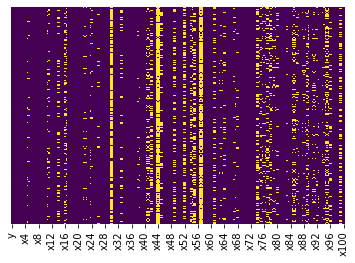

In [19]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

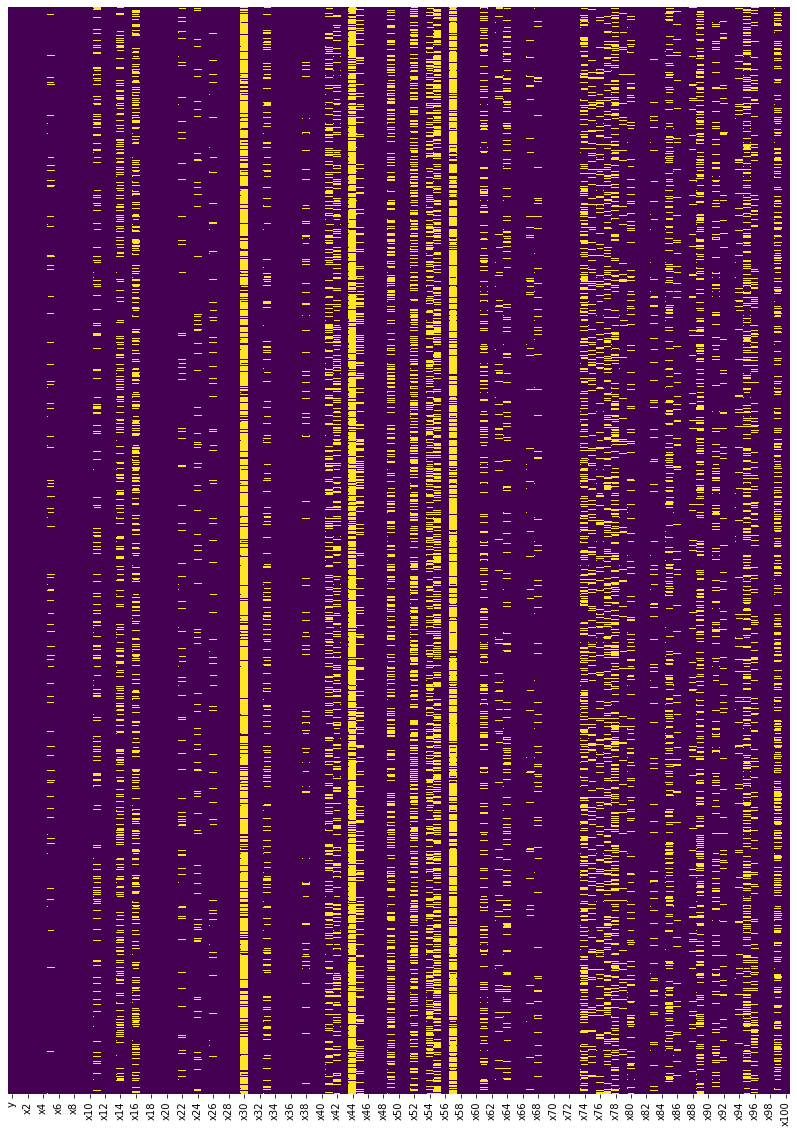

In [20]:
plt.rcParams["figure.figsize"] = [14,20] 
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [21]:
# get non-numeric features
df_train.dtypes [df_train.dtypes == 'O'].index

Index(['x3', 'x24', 'x31', 'x33', 'x39', 'x60', 'x65', 'x77', 'x93', 'x99'], dtype='object')

In [22]:
# Drop variables with high missing value ratio
var_drop  = get_missing_ratio(df_train)
print(f'Variables to be dropped owing to high missing ratio\n{var_drop}')
df_train = df_train.drop(var_drop, axis =1)
df_train.shape

missing_ratio 
 x5     0.061
x11    0.128
x14    0.247
x16    0.280
x22    0.060
x24    0.096
x26    0.061
x30    0.808
x33    0.179
x38    0.060
x41    0.238
x42    0.243
x44    0.856
x45    0.200
x49    0.321
x52    0.405
x54    0.318
x55    0.442
x57    0.812
x61    0.182
x63    0.060
x64    0.128
x67    0.061
x68    0.060
x74    0.323
x75    0.131
x76    0.131
x77    0.231
x78    0.284
x79    0.061
x80    0.131
x83    0.061
x85    0.243
x86    0.060
x88    0.058
x89    0.267
x91    0.131
x92    0.061
x94    0.058
x95    0.315
x96    0.166
x99    0.321
dtype: float64

Variables to be dropped owing to high missing ratio
['x30', 'x44', 'x52', 'x55', 'x57']


(40000, 96)

## Countplot for categorical features

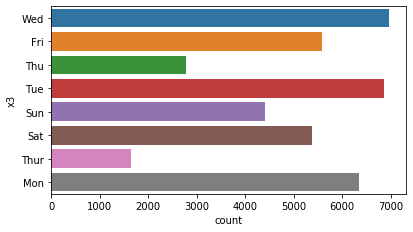

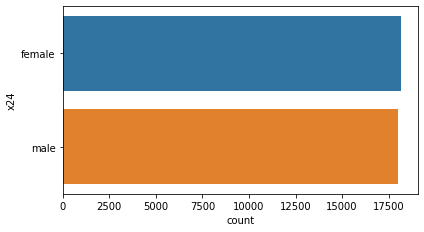

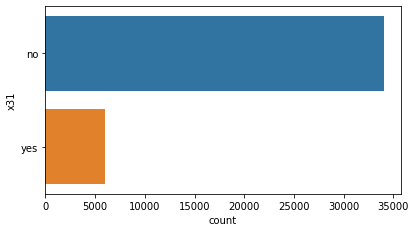

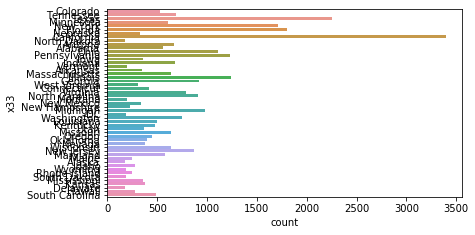

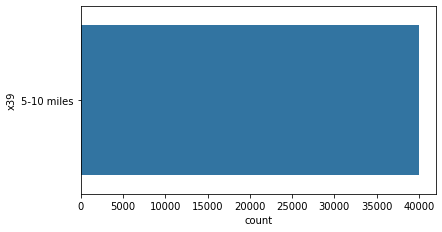

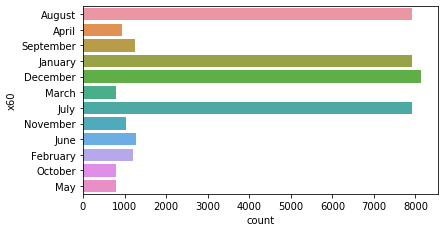

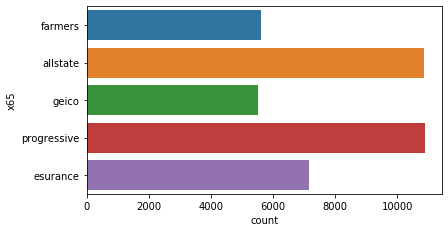

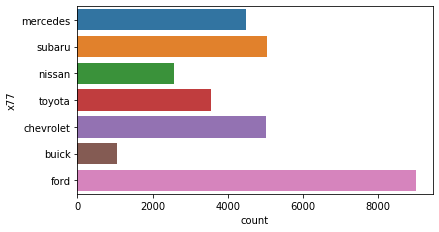

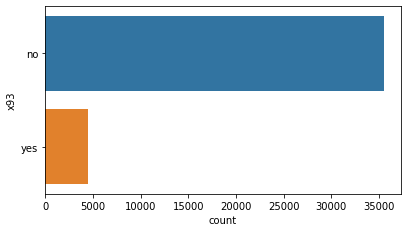

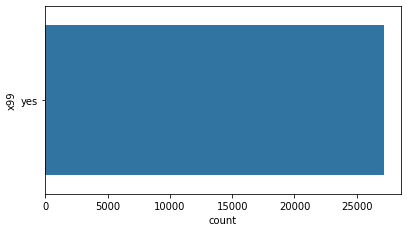

In [23]:
draw_countplot(df_train)

## Further investigation after countplot for X24, X39, and X99

In [24]:
"""
 -  All the values in x24 are 'male' and 'female' which are evenly distributed. Will drop x24
 -  All the values in x39 is '5-10 miles'. Will drop x39
"""

edp(df_train, 'x24')
edp(df_train, 'x39')
edp(df_train, 'x99')


 for feature x24
Misssing value ratio: 0.0964
Data typg e: object
Value counts 
female    0.45395
male      0.44965
Name: x24, dtype: float64

 for feature x39
Misssing value ratio: 0.0
Data typg e: object
Value counts 
5-10 miles    1.0
Name: x39, dtype: float64

 for feature x99
Misssing value ratio: 0.3209
Data typg e: object
Value counts 
yes    0.6791
Name: x99, dtype: float64


In [25]:
var_drop = ['x24', 'x39']


## Visulization for numerical features - Histagram¶

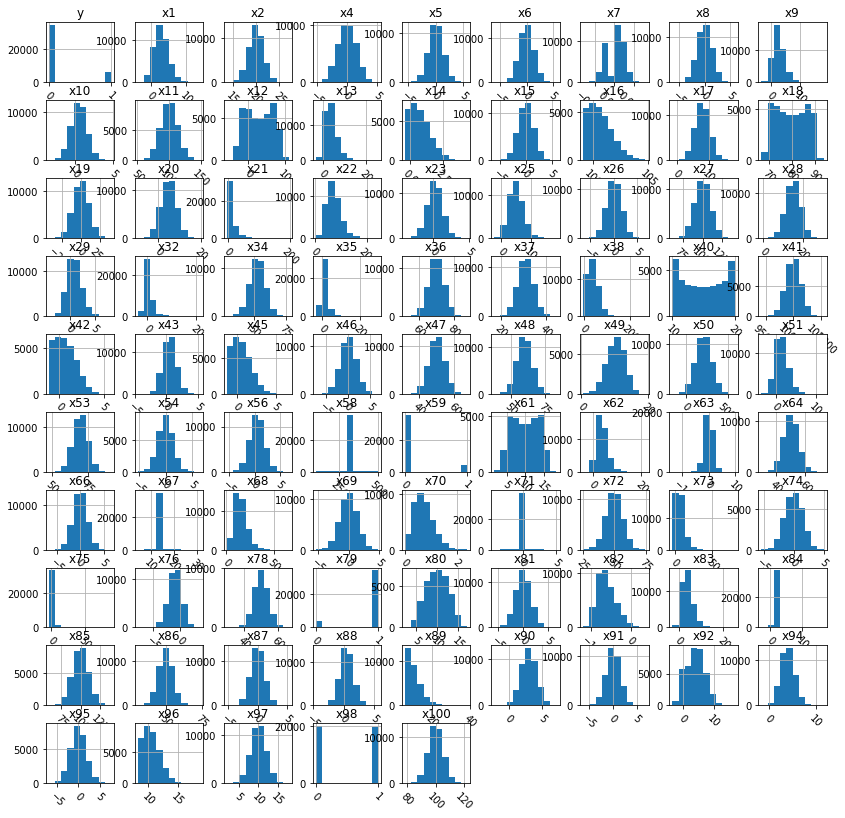

In [26]:

df_train.hist(figsize = (14, 14), xrot = -45)
plt.show()

###  Investigate the odd numerical features
- View the hist plot and determine odd numerical features required further investigation
 - The odd numeric features are x21, x3, x35, x58, x59, x67, x71, x75, x79, x84, x98
 - x21, x32, x35, and x75 look ok
 - For x58, x59, x67, x71, x79, x84 are dominated by a single value or a narrow range of values 
   - The percentile of 25th, 50th and 75th are identical 
   - They can be dropped. 
  - x98 has 50% with value of 1 and 49% with value of 0 
   - The value in x98 is 0 or 1 and they are evenly distributed. It can be dropped from modeling

In [27]:
odd_num_fea = ['x58', 'x59', 'x67', 'x71', 'x75', 'x79', 'x84', 'x98']
[df_train[feature].describe() for feature in odd_num_fea]


[count    40000.000000
 mean       300.422034
 std         35.005180
 min         98.627537
 25%        300.629990
 50%        300.629990
 75%        300.629990
 max        500.394945
 Name: x58, dtype: float64,
 count    40000.000000
 mean         0.099650
 std          0.299537
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max          1.000000
 Name: x59, dtype: float64,
 count    37575.000000
 mean        14.415957
 std          1.160265
 min          4.313964
 25%         14.402071
 50%         14.402071
 75%         14.402071
 max         31.407836
 Name: x67, dtype: float64,
 count    40000.000000
 mean         0.000997
 std          0.426451
 min         -4.378783
 25%         -0.000234
 50%         -0.000234
 75%         -0.000234
 max          5.018038
 Name: x71, dtype: float64,
 count    34755.000000
 mean         1.427536
 std          2.390149
 min         -3.803147
 25%          0.114082
 50%          1.019482
 75%          

In [28]:
# Invoke 'edp' to get  missing value ratio, data type and value count
edp(df_train, 'x59')
edp(df_train, 'x79')
edp(df_train, 'x98')


 for feature x59
Misssing value ratio: 0.0
Data typg e: int64
Value counts 
0    0.90035
1    0.09965
Name: x59, dtype: float64

 for feature x79
Misssing value ratio: 0.06075
Data typg e: float64
Value counts 
1.0    0.844625
0.0    0.094625
Name: x79, dtype: float64

 for feature x98
Misssing value ratio: 0.0
Data typg e: int64
Value counts 
0    0.50235
1    0.49765
Name: x98, dtype: float64


In [29]:
var_drop = ['x24', 'x39']
var_drop = var_drop + ['x58', 'x59', 'x67', 'x71', 'x79', 'x84', 'x98']
df_train = df_train.drop(var_drop, axis = 1)
df_train
df_train.shape

(40000, 87)

## Categorical feature encoding and missing value treatment 
  - Invoke 'impute_cat' to impute missing values 
  - Define a function 'tar_enc' to use target encoding to convert categorical feature to numerical feature
      - Will apply to all categorical features
      - e.g.,  x3(Days of the week), x33 (State), x65 (Insurance), and X77 (Car brand)   


In [30]:
num_fea = df_train.select_dtypes([np.number]).drop(['y'], axis = 1).columns
cat_fea = df_train.select_dtypes(exclude=[np.number]).columns

In [31]:
#Impute categorical features
for feature in cat_fea:
    df_train[feature] =  df_train[feature].fillna('missing') 


In [32]:
#Apply target encoding for df_train
for feature in cat_fea:
    tar_enc(df_train, feature)

### Impute numerical feature

In [33]:
 for feature in num_fea:
    if nr(df_train, feature) > 0:        
       impute_num(df_train, feature)

In [34]:
get_missing_ratio(df_train)

missing_ratio 
 Series([], dtype: float64)



[]

In [35]:
df_train.dtypes [df_train.dtypes == 'O'].index

Index([], dtype='object')

## scale the numerical features

In [36]:
X = df_train.drop('y', axis=1)
y = df_train['y']
X =  scale(df_train, with_mean=True, with_std=True)

## PCA - Principal Components Analysis
    - Applied PCA to reduce the features from 86 to 60 and transform the df_train

In [37]:
""" 
 n_ component  sum of explained_variance_ratio 
  40           0.8011
  50           0.8870 
  60           0.9455 
"""
X_pca = PCA(n_components= 60).fit_transform(X)  # numpy.ndarray


## ADASYN - to handle imbalance data
  - The ADASYN (adaptive synthetic sampling) approach
  - uses a weighted distribution for different minority class examples according to their level of difficulty in learning
    - where more synthetic data is generated for minority class examples that are harder to learn.

In [38]:

ada = ADASYN() 
X_resampled, y_resampled = ada.fit_sample(X_pca, y) 


In [39]:
clf = LogisticRegression() 
#clf.fit(X_resampled, y_resampled)

In [40]:
eval_mdl(clf, 'LogisticRegression', X_resampled, y_resampled)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
bld_mdl(clf)

In [ ]:
xgb = XGBClassifier()
bld_mdl(xgb)

In [ ]:

proba_clf = cross_val_predict(clf, X_resampled, y_resampled, cv=cv, method='predict_proba')  #numpy.ndarray
proba_xgb = cross_val_predict(xgb, X_resampled, y_resampled, cv=cv, method='predict_proba')  #numpy.ndarray


In [ ]:
# save models
save_mdl(clf, 'clf')
save_mdl(xgb, 'xgb')

## wip

In [ ]:
stop
cat_fea


In [ ]:
type(X_pca)

In [ ]:
print(f'AUC score Mean: {mean(scores):.3f}, Std: {std(scores):.3f}')

In [ ]:
df_train.x99[1:10]

In [ ]:
proba[0:10]

In [ ]:
from sklearn.model_selection import cross_val_predict
proba = cross_val_predict(clf, X_resampled, y_resampled, cv=cv, method='predict_proba')  #numpy.ndarray
#scores = cross_val_score(mdl, X_resampled, y_resampled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
print(xgb.feature_importances_)

In [ ]:
[print(f'{i} {x:0.5f}') for i, x in enumerate(xgb.feature_importances_)]

In [ ]:
#plt.figure(figsize=(14,20)) 
plt.rcParams["figure.figsize"] = [14,20] 
# plt.bar(x,y)
plot_importance(xgb)

In [ ]:
xgb.get_booster().feature_names

In [ ]:
plt.figure(figsize=(16,5))
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:

X_pca.shape

In [ ]:
clf.coef_